In [1]:
%matplotlib inline

import numpy as np
from clawpack import riemann
from clawpack import pyclaw

        
def qtrue(x,t):
    """
    The true solution, for comparison.  
    """
    from numpy import mod, exp, where, logical_and 
    beta = 100
    gamma = 0
    x0 = 0.75
    if isinstance(x,(np.ndarray,list)):
        m = np.size(x)
        q = np.empty((m))
        for i in range(m):
            xm = (np.sqrt(x[i])-t)**2
            if x[i] != 0.:
                q[i] = qinit(xm)/np.sqrt(x[i])*np.sqrt(xm)
            else:
                q[i] = 0.
    if isinstance(x,(float,int)):
        if x != 0:
            xm = (np.sqrt(x)-t)**2
            q = qinit(xm)/np.sqrt(x)*np.sqrt(xm)
        else:
            q = 0
    return q
        
def qinit(x):
    """
    The true solution, for comparison.  
    """
    from numpy import mod, exp, where, logical_and
    beta = 100
    gamma = 0
    x0 = 0.75
    q = exp(-beta * (x-x0)**2) + where(logical_and(x > 0.1, x < 0.4),  1, 0)
    q = where(logical_and(x > 0.1, x < 0.4),  1, 0)
    return q


def advection(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d linear advection riemann solver 
    """
    import numpy as np
    num_eqn = 1
    num_waves = 1

    # Convenience
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))

    delta = q_r - q_l
     
    
    # Compute the wave
    # 1-Wave
    wave[0,0,:] = delta 
    s[0,:] = (aux_l[0,:]+aux_r[0,:])/2.
    s_index = np.zeros((2,num_rp))
    s_index[0,:] = s[0,:]
    amdq[0,:] = np.min(s_index,axis=0) * wave[0,0,:]
    apdq[0,:] = np.max(s_index,axis=0) * wave[0,0,:]

    return wave, s, amdq, apdq


def source_term(solver, state, dt):
    from scipy.linalg import solve_banded
    import numpy as np
    qs = state.q[0,:]
    xc = state.grid.c_centers[0]
    dq = -qs/np.sqrt(xc) *dt
    state.q[0,:] = qs+dq


# Advection speed
def auxinit(state):
    xc = state.grid.x.centers
    state.aux[0,:] =  2*np.sqrt(xc)
    


def setup(outdir='./_output'):
    from clawpack import riemann


    #solver = pyclaw.ClawSolver1D(SpatialAdvection)
    #solver.kernel_language = 'Python'
    #solver = pyclaw.ClawSolver1D(riemann.advection_color_1D)
    solver = pyclaw.ClawSolver1D(advection)
    solver.kernel_language = 'Python'
    solver.num_waves = 1
    solver.num_eqn = 1
    
    
    solver.limiters = pyclaw.limiters.tvd.MC
    solver.bc_lower[0] = pyclaw.BC.extrap
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.aux_bc_lower[0] = pyclaw.BC.extrap
    solver.aux_bc_upper[0] = pyclaw.BC.extrap
    solver.step_source = source_term

    xlower = 0.0; xupper = 2.0; mx = 200
    x      = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    num_aux, num_eqn = 1, 1
    state  = pyclaw.State(domain,num_eqn,num_aux)

    xc = domain.grid.x.centers
    state.q[0,:] = qinit(xc)
    auxinit(state)

    claw = pyclaw.Controller()
    claw.outdir = outdir
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver

    claw.tfinal = 1
    claw.num_output_times = 20
    claw.keep_copy = True
    
    return claw


2024-04-01 15:11:12,080 INFO CLAW: Solution 0 computed for time t=0.000000


2024-04-01 15:11:13,334 INFO CLAW: Solution 1 computed for time t=0.050000
2024-04-01 15:11:13,344 INFO CLAW: Solution 2 computed for time t=0.100000
2024-04-01 15:11:13,353 INFO CLAW: Solution 3 computed for time t=0.150000
2024-04-01 15:11:13,363 INFO CLAW: Solution 4 computed for time t=0.200000
2024-04-01 15:11:13,372 INFO CLAW: Solution 5 computed for time t=0.250000
2024-04-01 15:11:13,381 INFO CLAW: Solution 6 computed for time t=0.300000
2024-04-01 15:11:13,389 INFO CLAW: Solution 7 computed for time t=0.350000
2024-04-01 15:11:13,397 INFO CLAW: Solution 8 computed for time t=0.400000
2024-04-01 15:11:13,405 INFO CLAW: Solution 9 computed for time t=0.450000
2024-04-01 15:11:13,416 INFO CLAW: Solution 10 computed for time t=0.500000
2024-04-01 15:11:13,424 INFO CLAW: Solution 11 computed for time t=0.550000
2024-04-01 15:11:13,431 INFO CLAW: Solution 12 computed for time t=0.600000
2024-04-01 15:11:13,438 INFO CLAW: Solution 13 computed for time t=0.650000
2024-04-01 15:11:13,4

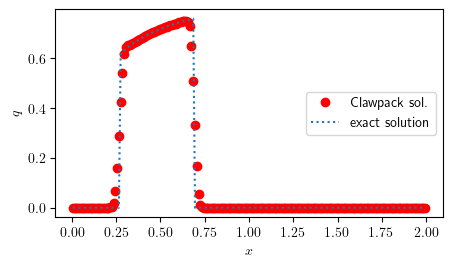

In [2]:

claw = setup()
claw.run()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
index = 4
frame = claw.frames[index]
dt = claw.tfinal/claw.num_output_times
t = dt*index
x = frame.state.grid.c_centers
x = x[0]

 
true = qtrue(x,t)
fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]

ax.plot(x, w, 'ro', label='Clawpack sol.')
ax.plot(x, true, ':',label='exact solution')
ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("SpatiallyVaryingAdvectionWithSource.pdf",bbox_inches='tight')

In [3]:
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    fig, ax = plt.subplots(figsize=(5, 3))
      
    frame = claw.frames[i]
    w = frame.q[0,:]
    x = frame.state.grid.c_centers
    x = x[0]
    dt = claw.tfinal/claw.num_output_times
    t = dt*i
    true = qtrue(x,t)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$q$')
    plt.plot(x, w)
    plt.plot(x, true, '--',color = 'r')
    figs.append(fig)
    plt.close(fig)
    
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs) 

interactive(children=(IntSlider(value=0, description='frameno', max=20), Output()), _dom_classes=('widget-inte…

In [4]:
def advection_animation(ul=2, ur=0, nu=0.5):
    import matplotlib.animation
    import numpy
    # compute the solution with the method defined above:
    claw = setup()
    claw.keep_copy = True
    claw.run()
    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0, 2.0, 200)
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.1, 2))
    axes.set_title("Advection equation")
    
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((-0.1,2.1))
        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'ro')
        exact_line, = axes.plot(x_true, qtrue(x_true,0.0), 'b--')
        return (computed_line, exact_line)
    
    computed_line, exact_line = init()
    
    def fplot(n):
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [qtrue(x_true,claw.frames[n].t)])
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=init, repeat=False)



In [5]:
from IPython.display import HTML 
anim = advection_animation()
HTML(anim.to_jshtml())

2024-04-01 15:11:20,491 INFO CLAW: Solution 0 computed for time t=0.000000
2024-04-01 15:11:20,499 INFO CLAW: Solution 1 computed for time t=0.050000
2024-04-01 15:11:20,507 INFO CLAW: Solution 2 computed for time t=0.100000
2024-04-01 15:11:20,515 INFO CLAW: Solution 3 computed for time t=0.150000
2024-04-01 15:11:20,521 INFO CLAW: Solution 4 computed for time t=0.200000
2024-04-01 15:11:20,529 INFO CLAW: Solution 5 computed for time t=0.250000
2024-04-01 15:11:20,539 INFO CLAW: Solution 6 computed for time t=0.300000
2024-04-01 15:11:20,546 INFO CLAW: Solution 7 computed for time t=0.350000
2024-04-01 15:11:20,553 INFO CLAW: Solution 8 computed for time t=0.400000
2024-04-01 15:11:20,560 INFO CLAW: Solution 9 computed for time t=0.450000
2024-04-01 15:11:20,568 INFO CLAW: Solution 10 computed for time t=0.500000
2024-04-01 15:11:20,576 INFO CLAW: Solution 11 computed for time t=0.550000
2024-04-01 15:11:20,583 INFO CLAW: Solution 12 computed for time t=0.600000
2024-04-01 15:11:20,59